In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os
import pathlib

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2", input_shape=IMAGE_SHAPE+(3,))
])

In [6]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(
    'flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

data_dir = pathlib.Path(data_dir)
data_dir

228827136/228813984 [==============================] - 2s 0us/step


PosixPath('datasets/flower_photos')

In [33]:
images = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

image_labels = []

with open(images, "r") as f:
  image_labels = f.read().splitlines()
  
image_labels[:5]


['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

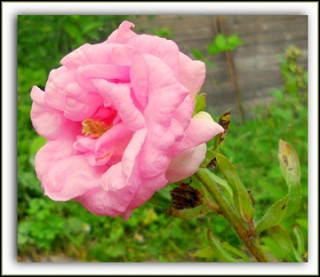

In [7]:
roses = list(data_dir.glob("roses/*"))
Image.open(roses[0])

In [8]:
# total number of images
len(list(data_dir.glob("*/*")))

3670

In [9]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}


In [10]:
# using opencv to read the image and convert it to numpy array
def read_image(image_path):
    image = cv2.imread(str(image_path))
    image = cv2.resize(image, IMAGE_SHAPE)
    return image

In [11]:
read_image(roses[0])

array([[[ 26,   2,   5],
        [  6,  13,  11],
        [  7,  11,  10],
        ...,
        [  9,  11,  11],
        [  6,  14,  11],
        [ 23,   2,   5]],

       [[  7,  18,  16],
        [ 72, 120, 113],
        [ 95, 131, 125],
        ...,
        [100, 132, 127],
        [ 72, 118, 110],
        [  7,  18,  16]],

       [[ 15,  22,  21],
        [122, 163, 156],
        [208, 232, 228],
        ...,
        [211, 232, 228],
        [125, 164, 158],
        [ 14,  22,  21]],

       ...,

       [[ 20,  22,  21],
        [119, 161, 154],
        [210, 235, 231],
        ...,
        [213, 235, 231],
        [120, 162, 155],
        [ 20,  22,  21]],

       [[  7,  16,  14],
        [ 66, 113, 105],
        [ 98, 131, 126],
        ...,
        [ 97, 131, 126],
        [ 66, 114, 106],
        [  6,  17,  14]],

       [[ 20,   2,   1],
        [  5,  11,   9],
        [ 11,  11,  10],
        ...,
        [ 10,  11,  10],
        [  5,  11,  10],
        [ 20,   1,   1]]

In [12]:
X, y = [], []

for flower_name, flower_images in flowers_images_dict.items():
    for image in flower_images:
        image = read_image(image)
        X.append(image/255)
        y.append(flowers_labels_dict[flower_name])

In [13]:
X = np.array(X)
y = np.array(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2936, 224, 224, 3), (734, 224, 224, 3), (2936,), (734,))

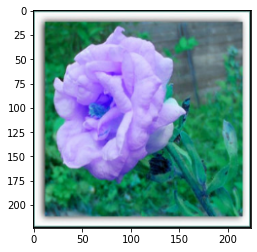

In [18]:
plt.imshow(X[0])

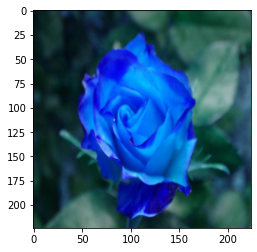

In [19]:
plt.imshow(X[1])

In [22]:
predicted = classifier.predict(np.array([X[0], X[1], X[2]]))
predicted = np.argmax(predicted, axis=1)
predicted

array([994, 116, 429])

In [30]:
image_labels[994] # its making a guess from the image labels of the pretrained model

'gyromitra'

In [34]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=IMAGE_SHAPE+(3,), trainable=False)


In [35]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 dense (Dense)               (None, 5)                 5010      
                                                                 
Total params: 3,545,275
Trainable params: 5,010
Non-trainable params: 3,540,265
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True),
    metrics=['acc'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
92/92 [==============================] - 77s 798ms/step - loss: 0.9022 - acc: 0.6918
Epoch 2/5
92/92 [==============================] - 74s 802ms/step - loss: 0.4108 - acc: 0.8549
Epoch 3/5
92/92 [==============================] - 74s 801ms/step - loss: 0.3164 - acc: 0.8869
Epoch 4/5
92/92 [==============================] - 73s 798ms/step - loss: 0.2689 - acc: 0.9118
Epoch 5/5
92/92 [==============================] - 73s 796ms/step - loss: 0.2325 - acc: 0.9264


In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
tf.test.is_built_with_cuda()

True

In [6]:
# check python version
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
